<a href="https://colab.research.google.com/github/Vats2025/Image-Classification/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Initializations and Dataset Download


In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Vatskhushboo
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:02<00:00, 358MB/s]


2. Imports

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


3. Reading Data Paths

In [ ]:
image_path = []
labels = []
# i = afhd, label = wild, cat, dog, imaegs = inside labels i.e. images
for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns = ["images_path", "labels"])

print(data_df["labels"].unique())
data_df.head()

['wild' 'cat' 'dog']


,images_path,labels
0,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
1,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
2,/content/animal-faces/afhq/val/wild/pixabay_wi...,wild
3,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
4,/content/animal-faces/afhq/val/wild/pixabay_wi...,wild


4. Data Split


In [ ]:
train = data_df.sample(frac = 0.7)
test = data_df.drop(train.index)

val = train.sample(frac=0.5)
train = train.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(5645, 2)
(4839, 2)
(5646, 2)


5. Preprocessing Objects

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"]) #Learn all unique class labels from the entire dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(), # from PIL format to tensor
    transforms.ConvertImageDtype(torch.float32)
    ])

6. Custom Dataset Class

In [ ]:
class CustomImageDataset(dataset.Dataset):
  def __init__(self, dataframe, transform = None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, index):
    img_path = self.dataframe.iloc[index, 0]
    label = self.labels[index]

    image = Image.open(img_path).convert("RGB")

    if self.transform:
      image = self.transform(image).to(device)

    return image, label

7. Create Dataset Objects


In [ ]:
train_dataset = CustomImageDataset(dataframe= train, transform = transform)
val_dataset = CustomImageDataset(dataframe= val, transform = transform)
test_dataset = CustomImageDataset(dataframe= test, transform = transform)

In [ ]:
  train_dataset.__getitem__(2)

(tensor([[[0.5412, 0.5255, 0.5020,  ..., 0.5765, 0.5882, 0.6196],
          [0.5098, 0.5020, 0.4745,  ..., 0.6235, 0.6196, 0.6196],
          [0.4745, 0.4627, 0.4392,  ..., 0.6314, 0.6157, 0.6078],
          ...,
          [0.8392, 0.8471, 0.8588,  ..., 0.8118, 0.8078, 0.7922],
          [0.8157, 0.8039, 0.7765,  ..., 0.7725, 0.7569, 0.7843],
          [0.7725, 0.8000, 0.7961,  ..., 0.7608, 0.7373, 0.7647]],
 
         [[0.4863, 0.4824, 0.4745,  ..., 0.5176, 0.5333, 0.5647],
          [0.4706, 0.4667, 0.4510,  ..., 0.5647, 0.5647, 0.5647],
          [0.4627, 0.4471, 0.4157,  ..., 0.5725, 0.5608, 0.5529],
          ...,
          [0.8392, 0.8471, 0.8549,  ..., 0.8157, 0.8078, 0.7961],
          [0.8157, 0.8039, 0.7765,  ..., 0.7686, 0.7569, 0.7843],
          [0.7725, 0.8000, 0.7961,  ..., 0.7490, 0.7255, 0.7569]],
 
         [[0.4863, 0.4784, 0.4667,  ..., 0.4902, 0.4941, 0.5216],
          [0.4667, 0.4588, 0.4392,  ..., 0.5373, 0.5255, 0.5216],
          [0.4510, 0.4353, 0.4039,  ...,

In [ ]:
label_encoder.inverse_transform([2])

array(['wild'], dtype=object)

8. Visualize Images


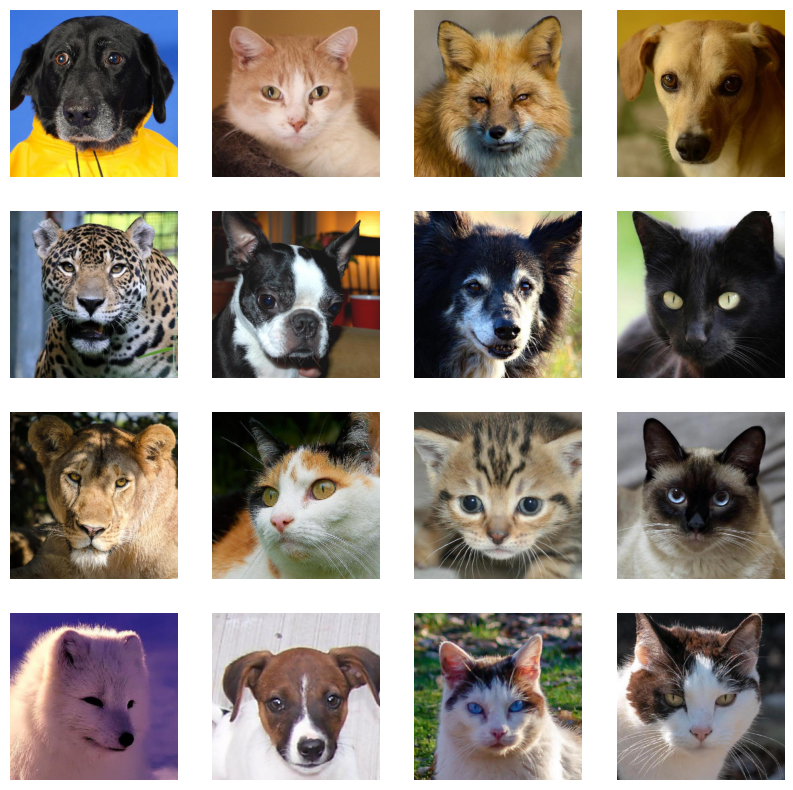

In [ ]:
#optional
n_rows = 4
n_cols = 4

f, axarr = plt.subplots(n_rows, n_cols, figsize = (10, 10))

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n = 1)["images_path"].iloc[0]).convert("RGB")
    axarr[row, col].imshow(image)
    axarr[row, col].axis("off")

plt.show()

9. Hyperparameters


In [ ]:
BATCH_SIZE = 10
EPOCHS = 20
LR = 1e-4

10. DataLoaders


In [ ]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

10. DataLoaders


In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3,  padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3,  padding=1)

    self.pooling = nn.MaxPool2d(2,2)

    self.relu = nn.ReLU()

    self.faltten = nn.Flatten()
    self.linear = nn.Linear((128*16*16), 128)

    self.output = nn.Linear(128, len(data_df["labels"].unique()))

  def forward(self, x):
    x = self.conv1(x) # -> (32, 128, 128)
    x = self.relu(x)
    x = self.pooling(x) # -> (32, 64, 64)


    x = self.conv2(x) # -> (64, 64, 64)
    x = self.relu(x)
    x = self.pooling(x) # -> (64, 32, 32)


    x = self.conv3(x) # -> (128, 32, 32)
    x = self.relu(x)
    x = self.pooling(x) # -> (128, 16, 16)


    x = self.faltten(x)
    x = self.linear(x)
    x = self.output(x)
    return x

In [ ]:
model = Net().to(device) # model

12. Model Summary


In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
              ReLU-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

ignore -1 as it is replced by any hyperparameters

13. Loss and Optimizer


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR) #parametr = weights

14. Training


In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

#Training
  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

#Validation
  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))

  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)


Epoch 1/20, Train Loss: 3.1478 Train Accuracy 76.1382
              Validation Loss: 1.7256 Validation Accuracy: 88.7708
Epoch 2/20, Train Loss: 1.3676 Train Accuracy 91.1072
              Validation Loss: 1.0612 Validation Accuracy: 93.305
Epoch 3/20, Train Loss: 0.9313 Train Accuracy 93.9947
              Validation Loss: 1.191 Validation Accuracy: 91.7818
Epoch 4/20, Train Loss: 0.6651 Train Accuracy 95.8547
              Validation Loss: 0.7703 Validation Accuracy: 94.9699
Epoch 5/20, Train Loss: 0.4754 Train Accuracy 97.2896
              Validation Loss: 0.6874 Validation Accuracy: 95.6784
Epoch 6/20, Train Loss: 0.3505 Train Accuracy 98.0159
              Validation Loss: 0.9223 Validation Accuracy: 94.1374
Epoch 7/20, Train Loss: 0.2348 Train Accuracy 98.6537
              Validation Loss: 1.016 Validation Accuracy: 93.9603
Epoch 8/20, Train Loss: 0.1542 Train Accuracy 99.1674
              Validation Loss: 0.7606 Validation Accuracy: 95.8023
Epoch 9/20, Train Loss: 0.1136 Trai

15. Testing


In [ ]:
#testing
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy score is: {round((total_acc_test/test_dataset.__len__())*100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy score is: 95.8049 and Loss is 0.104


16. Plotting Training Progress


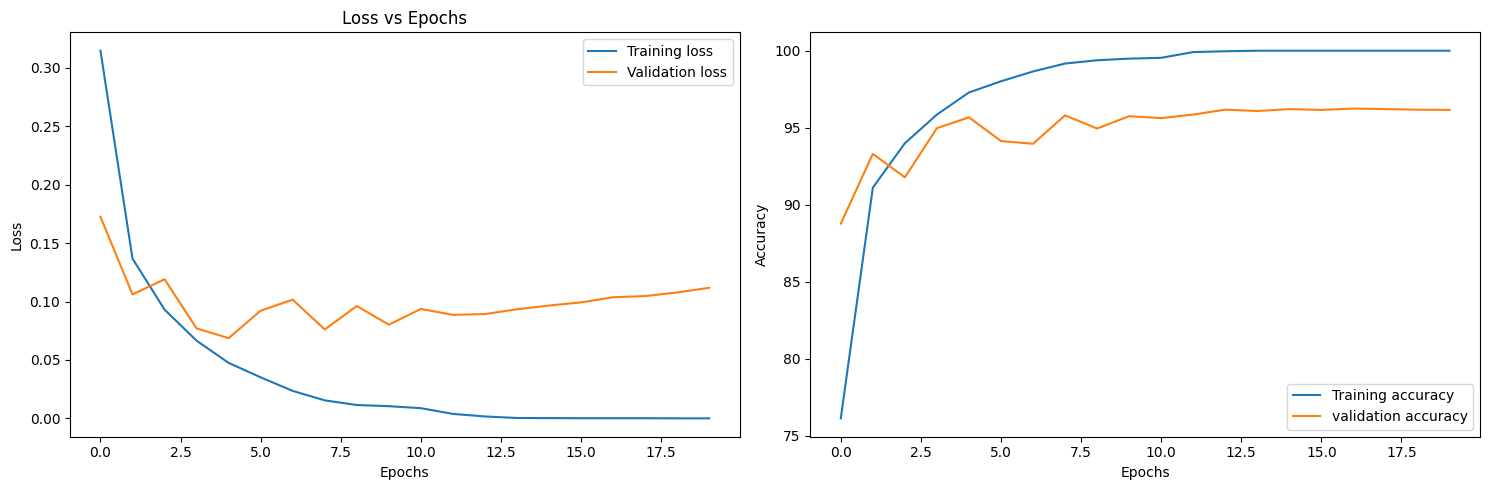

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label = "Training loss")
axs[0].plot(total_loss_validation_plot, label = "Validation loss")
axs[0].set_title("Loss vs Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Epochs")
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training accuracy")
axs[1].plot(total_acc_validation_plot, label = "validation accuracy")
axs[1].set_label("Accuracy vs Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

17. Inference


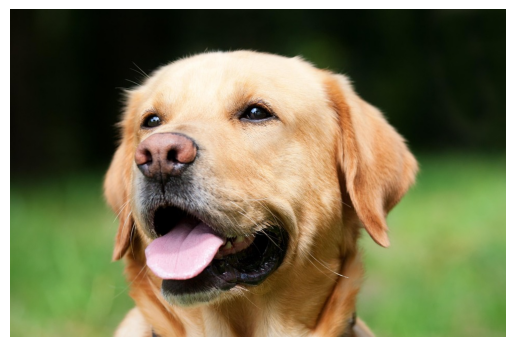


Prediction:

dog


In [ ]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)

    image = image.unsqueeze(0)  #batch dimension
    model.eval()
    with torch.no_grad():
        output = model(image)
        output = torch.argmax(output, axis=1).item()
        return label_encoder.inverse_transform([output])[0]

# Show image
img = Image.open("/content/dog-1194077_960_720.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()

# Predict
print("\nPrediction:\n")
print(predict_image("/content/dog-1194077_960_720.jpg"))
